# Ingesting UKDRI CRT Data with the DCARTE

## Derived datasets

We've already gone through how to use DCARTE to get UKDRI CRT raw datasets. However, a central element in the process of knowledge discovery (aka data science) is the creation of features that fuse different data sources, transform a single data source using some logic, or aggregate datasets to a relevant frequency.

Let's create a step by step example that will make this point simpler to follow. 

We start by importing dcarte and loading PIR Activity across the houses 

In [26]:
import dcarte 
import pandas as pd 
import seaborn as sns 
activity = dcarte.load('Activity','raw')
activity.start_date.agg(['min','max','count'])

Finished Loading Activity in:                  1.6 seconds   


min      2021-04-30 00:00:09
max      2022-02-20 06:07:09
count                5561396
Name: start_date, dtype: object

We then inspect the DataFrame's info()

In [7]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5561396 entries, 0 to 5561395
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   start_date     datetime64[ns]
 1   patient_id     object        
 2   home_id        object        
 3   location_id    object        
 4   location_name  object        
 5   source         object        
dtypes: datetime64[ns](1), object(5)
memory usage: 254.6+ MB


In this example, we wish to convert the raw activity data into a wide one-hot encoding tabular format that allows us to easily analyse the level of activity among households over time (e.g. every six hours every day or every week). One of the first things we should look at is the frequency of activity throughout the various locations in order to simplify the data by deleting or merging certain areas around the household. The best technique to find such targets is to use the pandas plotting capabilities.

<AxesSubplot:>

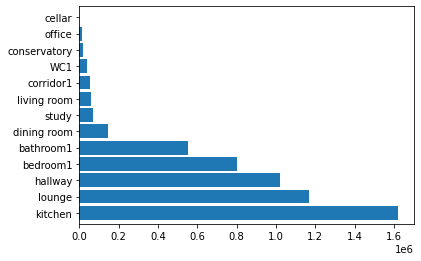

In [14]:
activity.location_name.value_counts().plot.barh()

The first step is to eliminate unique locations only in a few houses and combine contextually similar locations. This will make it easier to generalise our findings across all homes.

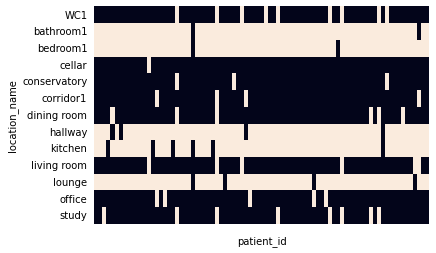

In [25]:

ax = sns.heatmap(pd.crosstab(activity.location_name,activity.patient_id)>0,cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);

A simple interpretation of the above plot can be to do the following cleaning tasks: 
- filter the cellar and the conservatory, 
- merge WC1 and bathroom1 
- merge study and office
- merge the lounge, dining room and living room
- merge the corridor and hallway 

Let's see an example of how to do this using pandas 


In [27]:
mask = ~activity.location_name.isin(['cellar','conservatory'])
activity = activity[mask]
activity.location_name.unique()

array(['bedroom1', 'bathroom1', 'hallway', 'lounge', 'kitchen',
       'living room', 'corridor1', 'dining room', 'WC1', 'study',
       'office'], dtype=object)

There are many ways to remap one value into another value in Python. However, in the process of transparency, interpretability and ease of change, I find the dictionary approach shown below to be the simplest to foolow and implement. 

In [29]:
mapping = {
    'bedroom1':'bedroom', 
    'bathroom1':'bathroom', 
    'hallway':'hallway', 
    'lounge':'lounge', 
    'kitchen':'kitchen',
    'living room':'lounge', 
    'corridor1':'hallway', 
    'dining room':'lounge', 
    'WC1':'bathroom', 
    'study':'study',
    'office':'study'}
activity.location_name = activity.location_name.map(mapping)
activity.location_name.unique()

array(['bedroom', 'bathroom', 'hallway', 'lounge', 'kitchen', 'study'],
      dtype=object)

Revisiting the plots we used before is a useful sanity check to validate that the changes we made we applied. 

<AxesSubplot:>

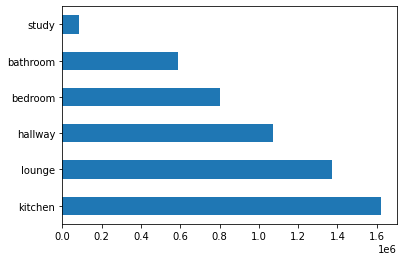

In [30]:
activity.location_name.value_counts().plot.barh()

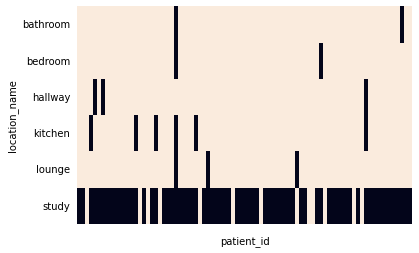

In [31]:
ax = sns.heatmap(pd.crosstab(activity.location_name,activity.patient_id)>0,cbar=False)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);

After cleaning the location_name we can select just columns of intrest by passing a list of columns names to the DataFrame. 

In [33]:
activity[['start_date','patient_id','location_name']]

,start_date,patient_id,location_name
0,2021-04-30 00:00:09,576646jHRwm4KkF9uzRnaC,bedroom
1,2021-04-30 00:00:32,EzjmQuxceJzLATdtyUbDn8,bedroom
2,2021-04-30 00:01:01,EzjmQuxceJzLATdtyUbDn8,bedroom
3,2021-04-30 00:01:37,EzjmQuxceJzLATdtyUbDn8,bedroom
4,2021-04-30 00:01:39,Hpbmfij5E6hh19u1uKFXQT,bedroom
...,...,...,...
5561391,2022-02-20 06:06:49,Xv41AaXiVYBKFAa7SLq8F5,bedroom
5561392,2022-02-20 06:06:54,YYGGmsEaf2gP4JNN9kMprV,bathroom
5561393,2022-02-20 06:07:00,9HYuS1aHmCBXidcwGhZBTm,hallway
5561394,2022-02-20 06:07:01,9HYuS1aHmCBXidcwGhZBTm,kitchen


Now, let's say we decide to merge the study with the lounge location, all we need to run the entire process again and update the mapping dictionary.  

In [51]:
activity = dcarte.load('Activity','raw')
mask = ~activity.location_name.isin(['cellar','conservatory'])
activity = activity[mask]
mapping = {
    'bedroom1':'bedroom', 
    'bathroom1':'bathroom', 
    'hallway':'hallway', 
    'lounge':'lounge', 
    'kitchen':'kitchen',
    'living room':'lounge', 
    'corridor1':'hallway', 
    'dining room':'lounge', 
    'WC1':'bathroom', 
    'study':'lounge',
    'office':'lounge'}
activity.location_name = activity.location_name.map(mapping)
activity.location_name.unique()

Finished Loading Activity in:                  1.3 seconds   


array(['bedroom', 'bathroom', 'hallway', 'lounge', 'kitchen'],
      dtype=object)

In the end, we now have a single dataset in which the majority of households are similar and there are very few homes with missing locations.

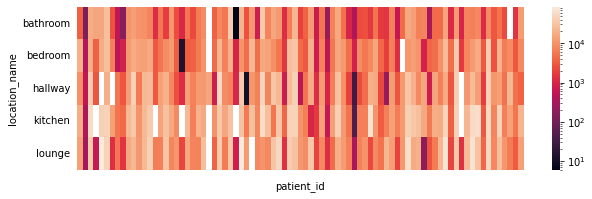

In [43]:
df = pd.crosstab(activity.location_name,activity.patient_id)
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,3))
sns.heatmap(df,  norm=LogNorm(),ax=ax)
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels([]);

Converting this dataset to a wide one-hot encoding format where time and patient ids are the indexes and the different locations are the columns requires calling a pandas function called `pd.get_dummies`.

In [53]:
activity = activity.set_index(['patient_id','start_date']).location_name
activity = pd.get_dummies(activity)
activity

bathroom  bedroom  hallway  \
patient_id             start_date                                        
576646jHRwm4KkF9uzRnaC 2021-04-30 00:00:09         0        1        0   
EzjmQuxceJzLATdtyUbDn8 2021-04-30 00:00:32         0        1        0   
                       2021-04-30 00:01:01         0        1        0   
                       2021-04-30 00:01:37         0        1        0   
Hpbmfij5E6hh19u1uKFXQT 2021-04-30 00:01:39         0        1        0   
...                                              ...      ...      ...   
Xv41AaXiVYBKFAa7SLq8F5 2022-02-20 06:06:49         0        1        0   
YYGGmsEaf2gP4JNN9kMprV 2022-02-20 06:06:54         1        0        0   
9HYuS1aHmCBXidcwGhZBTm 2022-02-20 06:07:00         0        0        1   
                       2022-02-20 06:07:01         0        0        0   
                       2022-02-20 06:07:09         0        1        0   

                                            kitchen  lounge  
patient_id             start_date                            
576646jHRwm4KkF9uzRnaC 2021-04-30 00:00:09        0       0  
EzjmQuxceJzLATdtyUbDn8 2021-04-30 00:00:32        0       0  
                       2021-04-30 00:01:01        0       0  
                       2021-04-30 00:01:37        0       0  
Hpbmfij5E6hh19u1uKFXQT 2021-04-30 00:01:39        0       0  
...                                             ...     ...  
Xv41AaXiVYBKFAa7SLq8F5 2022-02-20 06:06:49        0       0  
YYGGmsEaf2gP4JNN9kMprV 2022-02-20 06:06:54        0       0  
9HYuS1aHmCBXidcwGhZBTm 2022-02-20 06:07:00        0       0  
                       2022-02-20 06:07:01        1       0  
                       2022-02-20 06:07:09        0       0  

[5542493 rows x 5 columns]

It would be helpful to formalise this process so that it does not require us to run it each time. Formalising derived datasets is another aspect of dcarte that simplifies the collaborations on different parts of data processing. Dcarte comes armed with three samples derived datasets that can be available using a simple command. Running any of the three functions listed below will add a single domain to your dcarte library. These functions will automatically download needed datasets and create the different local datasets described internally.

In [54]:
from dcarte.derived import (create_base_datasets,
                            create_weekly_profile,
                            create_bed_occupancy)
create_base_datasets()

Finished Loading door in:                      0.2 seconds   
Finished Loading doors in:                     0.1 seconds   
Finished Loading environmental in:             3.1 seconds   
Finished Loading device_types in:              0.0 seconds   
Finished Loading appliances in:                0.0 seconds   
Finished Loading doors in:                     0.1 seconds   
Finished Loading activity in:                  1.3 seconds   
Finished Loading device_types in:              0.0 seconds   
Finished Loading activity in:                  1.1 seconds   
Finished Loading entryway in:                  0.0 seconds   
Finished Loading sleep_event in:               0.1 seconds   
Finished Loading vital_signs in:               0.0 seconds   
Finished Loading blood_pressure in:            0.0 seconds   
Finished Loading device_types in:              0.0 seconds   
Finished Loading sleep_mat in:                 1.1 seconds   
Finished Loading motion in:                    0.7 seconds   


In [55]:
create_weekly_profile()

Finished Loading motion in:                    0.6 seconds   
Finished Loading activity_dailies in:          0.0 seconds   
Finished Loading sleep in:                     1.9 seconds   
Finished Loading sleep_dailies in:             0.0 seconds   
Finished Loading physiology in:                0.0 seconds   
Finished Loading physiology_dailies in:        0.0 seconds   
Finished Loading Habitat in:                   0.5 seconds   
Finished Loading Habitat in:                   0.5 seconds   


In [56]:
create_bed_occupancy()

Finished Loading sleep in:                     2.0 seconds   


When you run dcarte.domains() for the final time, you will notice that you now have a greater number of domains under your control than before. In the following section, we will go over one of these recipes in detail and show you how to create an expansion of it on your own using the material you have gained so far in this tutorial.